In [1]:
from __future__ import division

from sqlalchemy import create_engine, MetaData, Table
import json
import math
import re
import csv
from itertools import izip_longest
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.ma as ma
import rpy2

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
db_url = "sqlite:///../data/encoding/participants-room1-041717.db"
table_name = 'turkdemo'
data_column_name = 'datastring'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

data = []
for row in rows:
    data.append(row[data_column_name])
    
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data if part is not None]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
#         print(record)
        if type(record['trialdata']) is list:

            record['trialdata'] = {record['trialdata'][0]:record['trialdata'][1]}
        record['trialdata']['uniqueid'] = record['uniqueid']
        
# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
def isNotNumber(s):
    try:
        float(s)
        return False
    except ValueError:
        return True

data = [record['trialdata'] for part in data for record in part]

# filter out fields that we dont want using isNotNumber function
filtered_data = [{k:v for (k,v) in part.items() if isNotNumber(k)} for part in data]
    
# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(filtered_data)

data_column_name = 'codeversion'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

versions = []
version_dict = {}
for row in rows:
    version_dict[row[0]]=row[data_column_name]

    
version_col = []
for idx,sub in enumerate(data_frame['uniqueid'].unique()):
    for i in range(sum(data_frame['uniqueid']==sub)):
        version_col.append(version_dict[sub])
data_frame['exp_version']=version_col

In [3]:
data=[]
indexes=[]
subjcb={}
for line in data_frame.iterrows():
    try:
        if 'Q2' in json.loads(line[1]['responses']):
            delete = False
        else:
            delete = True
    except:
        pass
    
    if delete:
        indexes.append(line[0])
    else:
        try:
            print(json.loads(line[1]['responses'])['Q1'])
            print(line[1]['uniqueid'])
            subjcb[line[1]['uniqueid']]=json.loads(line[1]['responses'])['Q1']
        except:
            pass
        

data_frame = data_frame.drop(data_frame.index[indexes])

0
debugINPUVW:debug8N26FG
0
debugUFVA2P:debugJLAZ0N

debugM1ST6Z:debugAK70WE
0
debugYU4YSL:debug4VBZC9
0
debugDPUZ0Y:debugN6JT7D

debugFW5RCP:debug2Z36O6
1
debugC4LYXZ:debugVHMZVJ
1
debugXBHV8V:debugCE8X7Y
2
debugXMMV3K:debugUHYVSL
2
debugR6PQOF:debugRWCY82
3
debug4N2BN6:debugFLXRL0
3
debugVTUWSX:debug22ATP8
3
debug6CD5NI:debugRWT4J0
4
debugRM0HP6:debugR2Y85B
4
debugTSUSOA:debugJTPR68
5
debug5T9B6M:debugOUVEDR
5
debugZMAMLC:debugQJJ8JU
5
debugHTH26H:debugB48XB7
1
debugQEQKGF:debug2VXLK0
2
debugM8L5U2:debugVSUCS5


In [4]:
data_frame['uniqueid'].unique()
subjcb

{u'debug4N2BN6:debugFLXRL0': u'3',
 u'debug5T9B6M:debugOUVEDR': u'5',
 u'debug6CD5NI:debugRWT4J0': u'3',
 u'debugC4LYXZ:debugVHMZVJ': u'1',
 u'debugDPUZ0Y:debugN6JT7D': u'0',
 u'debugFW5RCP:debug2Z36O6': u'',
 u'debugHTH26H:debugB48XB7': u'5',
 u'debugINPUVW:debug8N26FG': u'0',
 u'debugM1ST6Z:debugAK70WE': u'',
 u'debugM8L5U2:debugVSUCS5': u'2',
 u'debugQEQKGF:debug2VXLK0': u'1',
 u'debugR6PQOF:debugRWCY82': u'2',
 u'debugRM0HP6:debugR2Y85B': u'4',
 u'debugTSUSOA:debugJTPR68': u'4',
 u'debugUFVA2P:debugJLAZ0N': u'0',
 u'debugVTUWSX:debug22ATP8': u'3',
 u'debugXBHV8V:debugCE8X7Y': u'1',
 u'debugXMMV3K:debugUHYVSL': u'2',
 u'debugYU4YSL:debug4VBZC9': u'0',
 u'debugZMAMLC:debugQJJ8JU': u'5'}

In [5]:
# read in stimulus library
wordpool = pd.read_csv('../stimuli/cut_wordpool.csv')

# this function takes the data frame and returns subject specific data based on the subid variable
def filterData(data_frame,subid):
    filtered_stim_data = data_frame[data_frame['stimulus'].notnull() & data_frame['listNumber'].notnull()]
    filtered_stim_data = filtered_stim_data[filtered_stim_data['trial_type']=='single-stim']
    filtered_stim_data =  filtered_stim_data[filtered_stim_data['uniqueid']==subid]
    return filtered_stim_data

# this function parses the data creating an array of dictionaries, where each dictionary represents a trial (word presented) along with the stimulus attributes
def createStimDict(data):
    stimDict = []
    for index, row in data.iterrows():
        stimDict.append({
                'text': str(re.findall('>(.+)<',row['stimulus'])[0]),
                'color' : { 'r' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[0]),
                           'g' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[1]),
                           'b' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[2])
                           },
                'location' : {
                    'top': float(re.findall('top:(.+)\%;', row['stimulus'])[0]),
                    'left' : float(re.findall('left:(.+)\%', row['stimulus'])[0])
                    },
                'category' : wordpool['CATEGORY'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'size' : wordpool['SIZE'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'wordLength' : len(str(re.findall('>(.+)<',row['stimulus'])[0])),
                'firstLetter' : str(re.findall('>(.+)<',row['stimulus'])[0])[0],
                'listnum' : row['listNumber']
            })
    return stimDict

# this function loads in the recall data into an array of arrays, where each array represents a list of words
def loadRecallData(subid):
    recalledWords = []
    for i in range(0,16):
        try:
            f = open('../data/recall/' + subid + '/' + subid + '-' + str(i) + '.wav.flac.txt', 'rb')
            spamreader = csv.reader(f, delimiter=' ', quotechar='|')
        except (IOError, OSError) as e:
            print(e)
        for row in spamreader:
            recalledWords.append([i.strip('"') for i in row[0].split(',')])
    return recalledWords

# this function computes accuracy for a series of lists
def computeListAcc(stimDict,recalledWords):
    accVec = []
    for i in range(0,16):
        stim = [stim['text'] for stim in stimDict if stim['listnum']==i]
        recalled= recalledWords[i]
        
        acc = 0
        tmpstim = stim[:]
        for word in recalled:
            if word in tmpstim:
                tmpstim.remove(word)
                acc+=1
        accVec.append(acc/len(stim))
    return accVec

def getFeatures(stimDict):
    stimDict_copy = stimDict[:]
    for item in stimDict_copy:
        item['location'] = [item['location']['top'], item['location']['left']]
        item['color'] = [item['color']['r'], item['color']['g'], item['color']['b']]
        item.pop('text', None)
        item.pop('listnum', None)
    stimDict_copy = [stimDict_copy[i:i+16] for i in range(0, len(stimDict_copy), 16)]
    return stimDict_copy

In [6]:
# subjects who have completed the exp
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

pres_data = []
pres = []
rec = []

pres_exp9 = []
rec_exp9 = []
features_exp9 = []

uniqueID_1 = []

# for each subject that completed the experiment
for idx,sub in enumerate(subids[0:-3]):
    
    print('Running analysis for subject: ', sub)    
        
    # get the subjects data
    filteredStimData = filterData(data_frame,sub)
    
    # parse the subjects data
    stimDict = createStimDict(filteredStimData)
    sub_data = pd.DataFrame(stimDict)
    sub_data['subject']=idx
    sub_data['experiment']=filteredStimData['exp_version'].values[0]
    sub_data = sub_data[['experiment','subject','listnum','text','category','color','location','firstLetter','size','wordLength']]
    pres_data.append(sub_data)
    pres.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
    
    features = getFeatures(stimDict)

    # load in the recall data
    recalledWords = loadRecallData(sub)
    
    rec.append(recalledWords)
    
    if filteredStimData['exp_version'].values[0]=='0.0':
        print(idx,subjcb[sub])
        pres_exp9.append([list(sub_data[sub_data['listnum']==lst]['text'].values) for lst in sub_data['listnum'].unique()])
        rec_exp9.append(recalledWords)
        features_exp9.append(features)
        uniqueID_1.append(filteredStimData['uniqueid'].values[0])    

('Running analysis for subject: ', u'debugUFVA2P:debugJLAZ0N')
(0, u'0')
('Running analysis for subject: ', u'debugYU4YSL:debug4VBZC9')
(1, u'0')
('Running analysis for subject: ', u'debugDPUZ0Y:debugN6JT7D')
(2, u'0')
('Running analysis for subject: ', u'debugC4LYXZ:debugVHMZVJ')
(3, u'1')
('Running analysis for subject: ', u'debugXBHV8V:debugCE8X7Y')
(4, u'1')
('Running analysis for subject: ', u'debugXMMV3K:debugUHYVSL')
(5, u'2')
('Running analysis for subject: ', u'debugR6PQOF:debugRWCY82')
(6, u'2')
('Running analysis for subject: ', u'debug4N2BN6:debugFLXRL0')
(7, u'3')
('Running analysis for subject: ', u'debug6CD5NI:debugRWT4J0')
(8, u'3')
('Running analysis for subject: ', u'debugRM0HP6:debugR2Y85B')
(9, u'4')
('Running analysis for subject: ', u'debugTSUSOA:debugJTPR68')
(10, u'4')
('Running analysis for subject: ', u'debug5T9B6M:debugOUVEDR')
(11, u'5')
('Running analysis for subject: ', u'debugZMAMLC:debugQJJ8JU')
(12, u'5')


In [15]:
import quail
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
egg = quail.Egg(pres=pres_exp9, rec=rec_exp9, features=features_exp9)
listgroup=[['control']*4+['random']*4+['optimal']*4+['opposite']*4,['control']*4+['random']*4+['optimal']*4+['opposite']*4, ['control']*4+['random']*4+['optimal']*4+['opposite']*4,
           ['control']*4+['random']*4+['opposite']*4+['optimal']*4, ['control']*4+['random']*4+['opposite']*4+['optimal']*4,
           ['control']*4+['optimal']*4+['random']*4+['opposite']*4, ['control']*4+['optimal']*4+['random']*4+['opposite']*4,
           ['control']*4+['optimal']*4+['opposite']*4+['random']*4, ['control']*4+['optimal']*4+['opposite']*4+['random']*4,
           ['control']*4+['opposite']*4+['optimal']*4+['random']*4, ['control']*4+['opposite']*4+['optimal']*4+['random']*4,
           ['control']*4+['opposite']*4+['random']*4+['optimal']*4, ['control']*4+['opposite']*4+['random']*4+['optimal']*4]

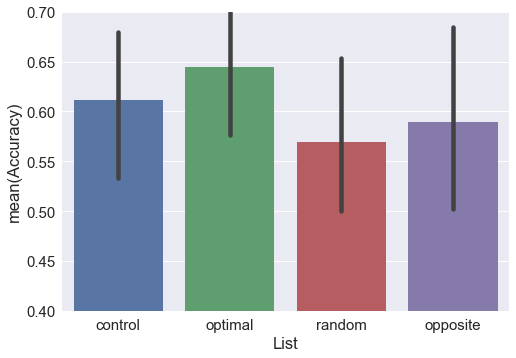

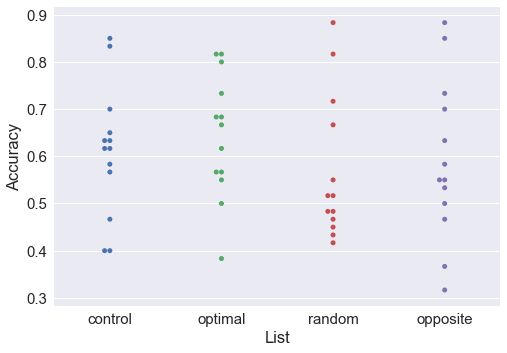

In [16]:
analyzed_egg = quail.analyze(egg, analysis='accuracy', listgroup=listgroup)
ax = quail.plot(analyzed_egg, ylim=[.4,.7])
ax = quail.plot(analyzed_egg, plot_style='swarm')

In [9]:
from scipy.stats import ttest_rel

df = pd.melt(analyzed_egg.T)
forward = df[df['List']=='optimal']['value']
backward = df[df['List']=='opposite']['value']
random = df[df['List']=='random']['value']


print('forward vs. backward: ', ttest_rel(forward,backward))
print('forward vs. random: ', ttest_rel(forward,random))

('forward vs. backward: ', Ttest_relResult(statistic=1.2744820668802743, pvalue=0.2266197388073406))
('forward vs. random: ', Ttest_relResult(statistic=2.217877943402728, pvalue=0.046615948225639275))


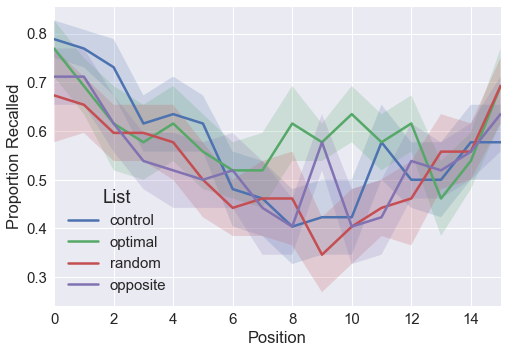

In [10]:
analyzed_egg = quail.analyze(egg, analysis='spc', listgroup=listgroup)
ax = quail.plot(analyzed_egg)

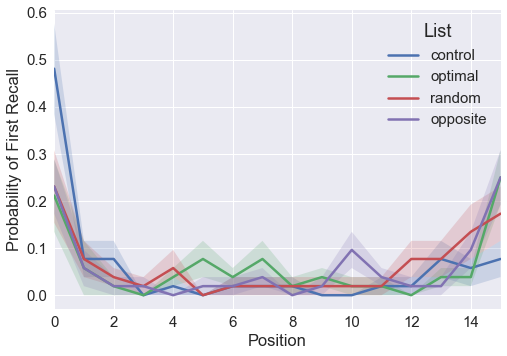

In [11]:
analyzed_egg = quail.analyze(egg, analysis='pfr', listgroup=listgroup)
ax = quail.plot(analyzed_egg)

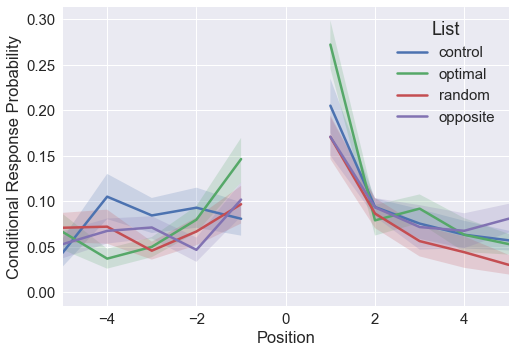

In [12]:
analyzed_egg = quail.analyze(egg, analysis='lagcrp', listgroup=listgroup)
ax = quail.plot(analyzed_egg)

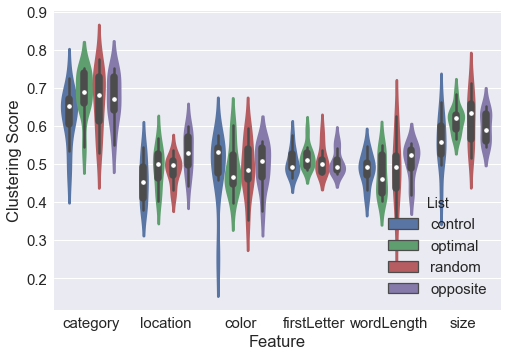

In [13]:
analyzed_egg = quail.analyze(egg, analysis='fingerprint', listgroup=listgroup)
ax = quail.plot(analyzed_egg)

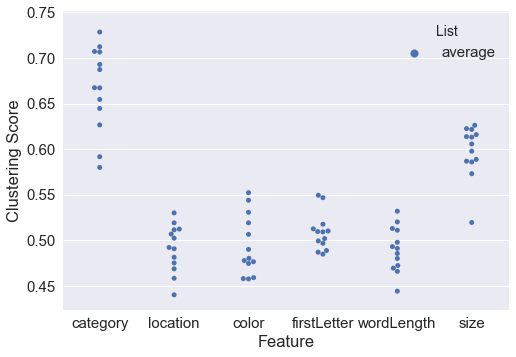

In [14]:
analyzed_egg = quail.analyze(egg, analysis='fingerprint', listgroup=['average']*16)
ax = quail.plot(analyzed_egg, plot_style='swarm')